In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL

## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 100
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
original_dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
original_stats = pd.DataFrame.from_dict(original_dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_04-discrimination_dataset"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
new_stats = pd.DataFrame.from_dict(dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
dset.worms_properties_stats = original_dset.worms_properties_stats
dset.worms_properties = (
    dset.worms_properties[:] * new_stats.loc["std"].to_numpy()
    + new_stats.loc["mean"].to_numpy()
    - original_stats.loc["mean"].to_numpy()
) / original_stats.loc["std"].to_numpy()
dloader = DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=12)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "full", "model": [model]}),
        ]
    ).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
for folder in list(np.sort(glob.glob("../figures/stats-panel/feedback-with-values*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_vals", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

for folder in list(np.sort(glob.glob("../figures/stats-panel/feedback-with-estimates*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat(
        [
            models,
            pd.DataFrame(
                {"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type": "feedback_esti", "model": [model]}
            ),
        ]
    ).reset_index(drop=True)

In [7]:
models = models[models["lambda_RC"] > 0].reset_index(drop=True)
models = models[models["model_type"]=="full"].reset_index(drop=True)

In [8]:
models

,rand_seed,lambda_RC,model_type,model
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


## Inspect discrimination data

In [9]:
eis = next(iter(dloader))[0]
props = next(iter(dloader))[1].to(torch.float32)
discrimination_data = raw_dataset["worms"]["dataframe"].copy()
discrimination_data["preferred"] = (discrimination_data["resistances"] == 0) & (
    discrimination_data["capacitances"] == 1
)
max_mod = eis[:, :, 5, 6]
print(eis.shape, max_mod.shape)

torch.Size([24, 2, 20, 30]) torch.Size([24, 2])


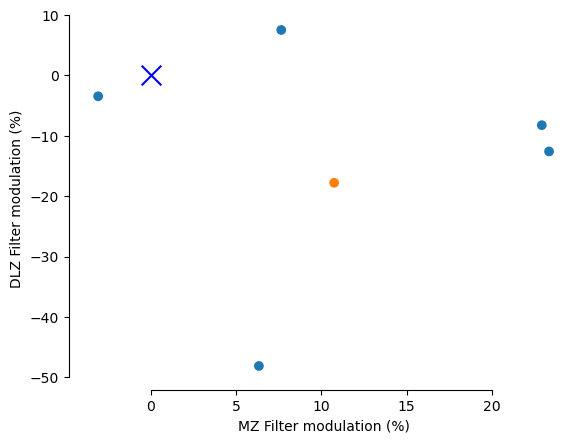

In [95]:
mask = raw_dataset["worms"]["dataframe"]["position_ys"] == 0
mask &= raw_dataset["worms"]["dataframe"]["radii"] == 1
plt.scatter(*eis[mask, :, 5, 6].T, c=[f"C{int(x)}" for x in discrimination_data[mask]["preferred"]])
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.savefig("discrimination-feat-space.svg")
plt.show()

### Create discrimination training and testing data

In [185]:
n_repeats = 100
train_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
train_eis = train_eis + torch.randn_like(train_eis) * 0.02
train_props = torch.tile(props, (n_repeats, 1))
labels = np.tile(discrimination_data["preferred"].to_numpy().astype(int), (n_repeats,))
valid_eis = torch.tile(eis, (n_repeats, 1, 1, 1))
valid_eis = valid_eis + torch.randn_like(valid_eis) * 0.02
valid_props = pd.concat([discrimination_data[["resistances", "capacitances", "radii", "position_ys", "preferred"]]] * n_repeats)
valid_props["preferred"] = valid_props["preferred"].astype(int)

## Compute models predictions

In [186]:
models["prediction_train"] = models.apply(
    lambda x: (
        x["model"].model(train_eis, train_props[:, 1], train_props[:, 3]).detach().cpu().numpy()
        if x["model_type"] == "feedback_vals"
        else x["model"].model(train_eis).detach().cpu().numpy()
    ),
    axis=1,
)
models["prediction_valid"] = models.apply(
    lambda x: (
        x["model"].model(valid_eis, train_props[:, 1], train_props[:, 3]).detach().cpu().numpy()
        if x["model_type"] == "feedback_vals"
        else x["model"].model(valid_eis).detach().cpu().numpy()
    ),
    axis=1,
)

In [187]:
def train_discrimination(dfrow):
    shuffle_perm = np.random.permutation(len(dfrow["prediction_train"]))
    train_x = dfrow["prediction_train"][shuffle_perm]
    train_y = labels[shuffle_perm]
    rfc = RandomForestClassifier(n_estimators=100, max_depth=10, class_weight="balanced", n_jobs=-1)
    rfc.fit(train_x, train_y)
    train_preds = rfc.predict(train_x)
    valid_x = dfrow["prediction_valid"]
    valid_y = labels
    valid_preds = rfc.predict(valid_x)

    dfrow["train_accuracy"] = (train_preds == train_y).mean()
    dfrow["train_preds"] = train_preds
    dfrow["train_probs"] = rfc.predict_proba(train_x)[:, 1]

    dfrow["valid_accuracy"] = (valid_preds == valid_y).mean()
    dfrow["valid_preds"] = valid_preds
    dfrow["valid_probs"] = rfc.predict_proba(valid_x)[:, 1]
    return dfrow

In [188]:
models = models.apply(train_discrimination, axis=1)

In [189]:
np.unique(models["train_preds"][3], return_counts=True), np.unique(models["valid_preds"][3], return_counts=True)

((array([0, 1]), array([1998,  402])), (array([0, 1]), array([2012,  388])))

In [190]:
models.head()

,rand_seed,lambda_RC,model_type,model,prediction_train,prediction_valid,train_accuracy,train_preds,train_probs,valid_accuracy,valid_preds,valid_probs,predicted_resistances,predicted_capacitances
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.1626208, -1.752554, 0.09728562, -1.134484,...","[[1.1748394, -1.7582322, 0.042989254, -1.13523...",1.000000,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...","[0.006421954688963676, 0.0, 0.00625, 0.0008571...",0.990000,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.10956424694629863, 0.0, 0.0, 0.9994974...","[3189.3044, 4867.267, 4345.448, 4890.8354, 214...","[4.9265947e-10, 7.803221e-10, 2.8924987e-10, 4..."
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.1975245, -1.8442922, 0.13673218, -1.253246...","[[1.2534916, -1.8492199, 0.08096357, -1.357839...",0.997917,"[0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, ...","[0.007484298806940916, 0.0, 0.7159784883334046...",0.982917,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.02, 0.0, 0.0, 1.0, 0.9784833795044723,...","[3010.9282, 2161.4866, 2648.7507, 2624.5767, 9...","[4.6462423e-10, 4.935593e-10, 4.312143e-10, 4...."
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.0661373, -1.8556938, -0.026647672, -1.3625...","[[1.0934718, -1.855439, -0.065593526, -1.37650...",0.999167,"[0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.6815149787198115, 0.0052252873950...",0.990000,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.9971448905430155, 0.965...","[1446.9414, 1621.278, 1573.4888, 2215.3242, 17...","[2.9834846e-10, 4.146544e-10, 3.084863e-10, 3...."
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.133951, -1.823777, 0.10416267, -1.2787783,...","[[1.1198025, -1.8756633, 0.05825872, -1.327299...",0.999167,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, ...","[0.043340696189056845, 0.0, 0.0, 0.0, 0.0, 0.0...",0.987500,"[0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.9995055794351115, 0.928...","[2328.5405, 2781.8735, 2992.178, 3464.4626, 17...","[4.3722223e-10, 5.419428e-10, 5.361428e-10, 4...."
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"[[1.2334415, -1.716728, 0.050950374, -1.122259...","[[1.2579204, -1.8521385, -0.060047608, -1.1649...",0.998750,"[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ...","[0.0, 0.9871458149125248, 0.0, 0.0, 0.88744093...",0.990000,"[0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.01, 0.01, 0.0, 0.0, 0.9980954422750778, 0.9...","[2314.6318, 2300.7925, 1929.288, 2634.653, 144...","[4.4336063e-10, 4.763279e-10, 3.8421788e-10, 4..."


In [191]:
valid_stats = pd.DataFrame()
for _, row in models.iterrows():
    model_id = row.name
    valid_props["predictions"] = row["valid_preds"]
    temp_valid_stats = valid_props.groupby(["resistances", "capacitances", "radii", "position_ys"]).apply(
        lambda x: (x["predictions"] == 1).sum() / x.shape[0]
    )
    temp_valid_stats.name="percent_intakes"
    temp_valid_stats = temp_valid_stats.reset_index()
    temp_valid_stats["model_id"] = model_id
    temp_valid_stats["model_type"] = row["model_type"]
    valid_stats = pd.concat([valid_stats, temp_valid_stats], axis=0)
valid_stats = valid_stats.reset_index(drop=True)
valid_stats = valid_stats.groupby(["model_type", "resistances", "capacitances", "radii", "position_ys"]).apply(lambda x: pd.Series([x["percent_intakes"].mean(), x["percent_intakes"].std()]))
valid_stats.columns = ["mean", "std"]
valid_stats = valid_stats.reset_index()

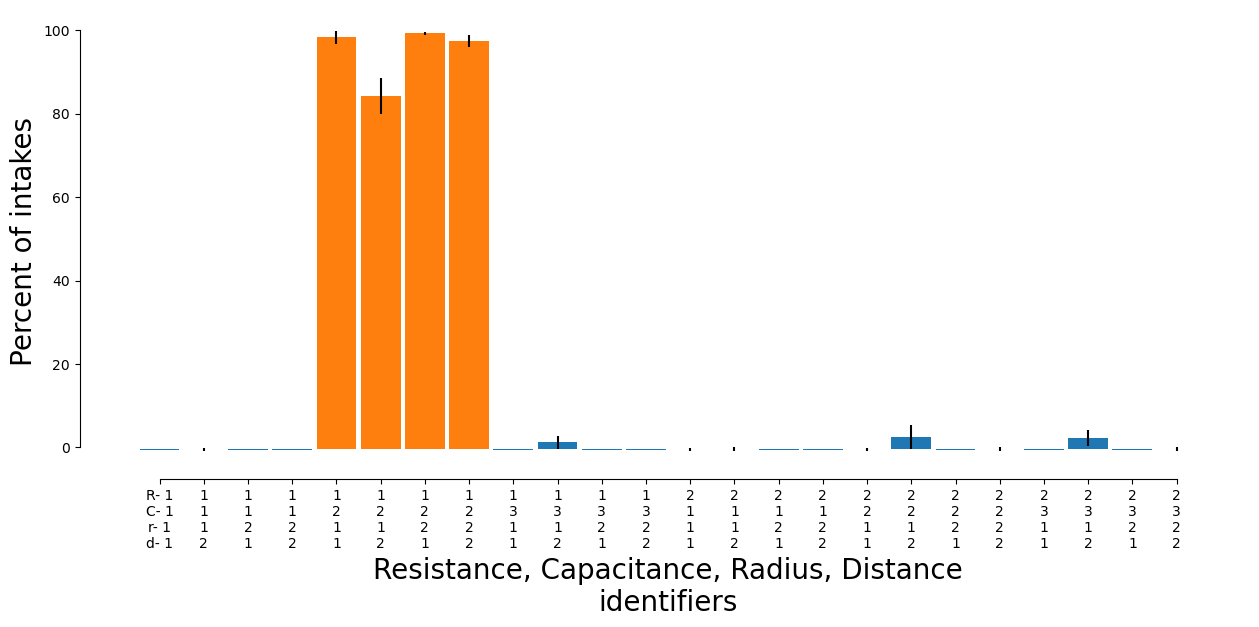

In [192]:
fig = plt.figure(figsize=(15, 6))
offset = -0.3
ticks = []
for i, row in valid_stats.iterrows():
    c = "C1" if row["resistances"] == 0 and row["capacitances"] == 1 else "C0"
    plt.bar(
        x=i,
        height=row["mean"] * 100 + offset,
        yerr=row["std"] * 100,
        bottom=offset,
        color=c,
        width=0.9,
    )
    if i == 0:
        ticks.append(
            [
                i,
                f"R- {row["resistances"]+1:.0f}\nC- {row["capacitances"]+1:.0f}\nr- {row["radii"]+1:.0f}\nd- {row["position_ys"]+1:.0f}",
            ]
        )
    else:
        ticks.append(
            [
                i,
                f"{row["resistances"]+1:.0f}\n{row["capacitances"]+1:.0f}\n{row["radii"]+1:.0f}\n{row["position_ys"]+1:.0f}",
            ]
        )
plt.xticks(*zip(*ticks))
plt.ylabel("Percent of intakes", fontsize=20)
plt.xlabel("Resistance, Capacitance, Radius, Distance\nidentifiers", fontsize=20)
sns.despine(offset=5, trim=True)
plt.savefig("discrimination-performance.svg")
plt.show()

## Inspect errors made by the models in feature space

### Collect properties based on models predictions

In [193]:
models["predicted_resistances"] = models.apply(
    lambda x: np.power(
        10,
        np.hstack(
            [
                x["prediction_train"][:, -2] * dset.worms_properties_stats["resistances"]["std"]
                + dset.worms_properties_stats["resistances"]["mean"],
                x["prediction_valid"][:, -2] * dset.worms_properties_stats["resistances"]["std"]
                + dset.worms_properties_stats["resistances"]["mean"],
            ]
        ),
    ),
    axis=1,
)
models["predicted_capacitances"] = models.apply(
    lambda x: np.power(
        10,
        np.hstack(
            [
                x["prediction_train"][:, -1] * dset.worms_properties_stats["capacitances"]["std"]
                + dset.worms_properties_stats["capacitances"]["mean"],
                x["prediction_valid"][:, -1] * dset.worms_properties_stats["capacitances"]["std"]
                + dset.worms_properties_stats["capacitances"]["mean"],
            ]
        ),
    ),
    axis=1,
)
predicted_resistances = np.hstack(models["predicted_resistances"])
predicted_capacitances = np.hstack(models["predicted_capacitances"])
all_properties = pd.concat(
    [discrimination_data[["resistances", "capacitances", "radii", "position_ys", "preferred"]]]
    * (predicted_resistances.shape[0] // len(discrimination_data))
)
all_properties["predicted_resistances"] = predicted_resistances
all_properties["predicted_capacitances"] = predicted_capacitances
all_properties = all_properties[
    (all_properties["resistances"] == 0)
    & (all_properties["capacitances"] == 1)
    & (all_properties["radii"] == 1)
    & (all_properties["position_ys"] == 0)
]
all_properties["position_xs"] = raw_dataset["worms"]["position_xs"][0]
all_properties["position_zs"] = raw_dataset["worms"]["position_zs"][0]
all_properties["radii"] = all_properties["radii"].apply(lambda x: raw_dataset["worms"]["radii"][x])
all_properties["position_ys"] = all_properties["position_ys"].apply(lambda x: raw_dataset["worms"]["position_ys"][x])
all_properties["resistances"] = all_properties["predicted_resistances"]
all_properties["capacitances"] = all_properties["predicted_capacitances"]
all_properties = all_properties.drop(columns=["predicted_resistances", "predicted_capacitances", "preferred"]).reset_index(drop=True)
all_properties.shape

(2000, 6)

### Run physics simulations to generate the EIs

In [194]:
sys.path.append("../../efish-physics-model/objects")
from Worm_SmallSpherical import SmallSphericalWorm  # noqa E402

In [195]:
fish_u = 30
fish_t = 20
aquarium = raw_dataset["aquarium"]["dataframe"]["objs"].iloc[0]
aquarium.empty_aquarium()
efish = raw_dataset["fish"]["dataframe"]["objs"].iloc[0]

In [196]:
aquarium.insert_fish(efish)

_, base_E_field_mag, wave_form = aquarium.electric_potential_and_field_single_fish(
    points=efish.get_receptors_locations(), fish_id=0, return_potential=False, return_field=True
)
base_E_field_full = base_E_field_mag * wave_form
base_transdermal_signal = efish.compute_transdermal_signal(
    E_field=base_E_field_mag.squeeze().reshape(-1, 3),
    water_conductivity=aquarium.get_conductivity(),
    temporal_wave_form=wave_form,
)
base_receptors_responses = efish.compute_receptors_responses(base_transdermal_signal)
base_receptors_responses = base_receptors_responses.reshape(fish_u, fish_t, 2).transpose(2, 1, 0)

aquarium.empty_aquarium()

In [197]:
estimated_eis = []
for _, worm_property in all_properties.iterrows():
    worm = SmallSphericalWorm(
        radius=worm_property["radii"],  # type: ignore
        resistance=worm_property["resistances"],  # type: ignore
        capacitance=worm_property["capacitances"],  # type: ignore
        center_position=[
            worm_property["position_xs"],
            worm_property["position_ys"],
            worm_property["position_zs"],
        ],
        _init_tests=False,
    )
    aquarium.insert_fish(efish)
    aquarium.insert_worm(worm)

    dipole_wave_form = worm.dipole_waveform_single_fish(
        wave_form=wave_form,
        sig_water=aquarium.get_conductivity(),
        eps_r_water=aquarium.get_relative_permittivity(),
        sampling_frequency=efish.get_sampling_rate(),
    )

    _, E_field, _ = aquarium.electric_potential_and_field_single_fish(
        points=worm.get_position()[np.newaxis],
        fish_id=0,
        return_potential=False,
        return_field=True,
    )
    perturbation_magnitude = worm.perturbation_magnitude_single_fish(
        receptor_locs=efish.get_receptors_locations(),
        E_field=E_field,
        return_potential=False,
        return_field=True,
        include_radius_factor=False,
    )[1]
    E_field_perturbation = np.power(worm.get_radius(), 3) * perturbation_magnitude[:, :, np.newaxis] * dipole_wave_form

    total_E_field = base_E_field_full + E_field_perturbation
    pert_transdermal_signal = efish.compute_transdermal_signal(
        E_field=total_E_field, water_conductivity=aquarium.get_conductivity()
    )

    pert_receptors_responses = efish.compute_receptors_responses(pert_transdermal_signal)
    pert_receptors_responses = pert_receptors_responses.reshape(fish_u, fish_t, 2).transpose(2, 1, 0)
    
    estimated_eis.append((pert_receptors_responses / base_receptors_responses - 1) *100)
    
    aquarium.empty_aquarium()
estimated_eis = np.array(estimated_eis)

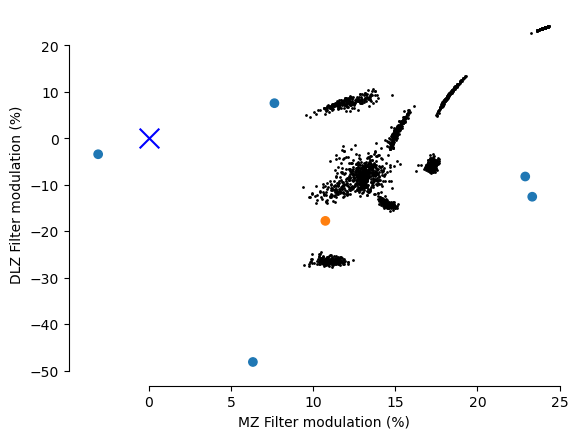

In [198]:
mask = raw_dataset["worms"]["dataframe"]["position_ys"] == 0
mask &= raw_dataset["worms"]["dataframe"]["radii"] == 1
plt.scatter(*eis[mask, :, 5, 6].T, c=[f"C{int(x)}" for x in discrimination_data[mask]["preferred"]])
plt.scatter([0], [0], c="b", marker="x", s=200)
plt.scatter(*estimated_eis[:, :, 5, 6].T, c="k", s=1)
plt.xlabel("MZ Filter modulation (%)")
plt.ylabel("DLZ Filter modulation (%)")
sns.despine(offset=5, trim=True)
plt.show()

## Inspect models predictions

In [ ]:
from sklearn.decomposition import PCA

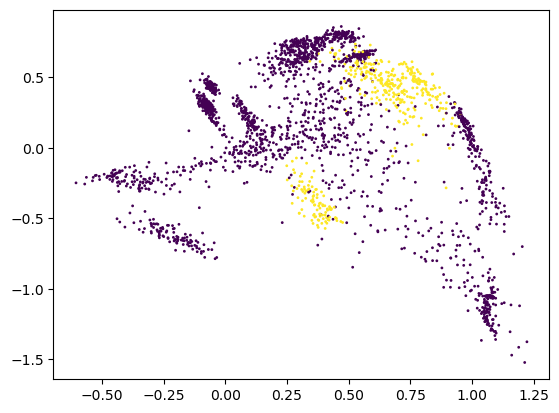

In [200]:
xx = models.iloc[0]["prediction_valid"]
plt.scatter(xx[:, -2], xx[:, -1], c=valid_props["preferred"], s=1)
plt.show()

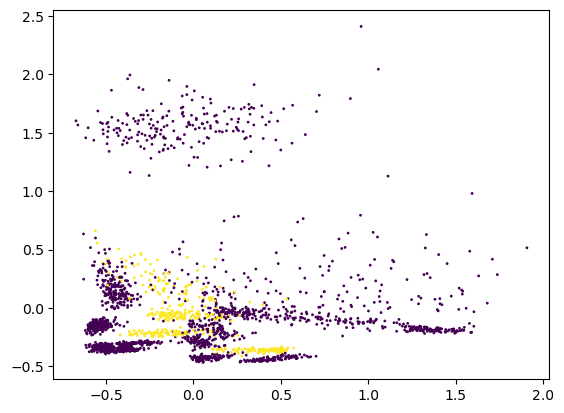

In [141]:
yy = PCA().fit_transform(xx)
plt.scatter(yy[:, 0], yy[:, 1], c=valid_props["preferred"], s=1)
plt.show()